### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from fastai.vision.all import *
from fastai import *

set_seed(42) #Set random seed to a constant so tests are reproducible


### Set paths

In [2]:
path = Path('../input/cassava-leaf-disease-classification')
path.ls()

(#7) [Path('../input/cassava-leaf-disease-classification/train_tfrecords'),Path('../input/cassava-leaf-disease-classification/sample_submission.csv'),Path('../input/cassava-leaf-disease-classification/test_tfrecords'),Path('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('../input/cassava-leaf-disease-classification/train_images'),Path('../input/cassava-leaf-disease-classification/train.csv'),Path('../input/cassava-leaf-disease-classification/test_images')]

### Read training data csv

In [3]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


### Add 'train_images/' to image_id column to easily access directory

In [4]:
train_df['image_id'] = 'train_images/' + train_df['image_id']
train_df.head()

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3


### Add qualitative labels

In [5]:
import json
with open(path/'label_num_to_disease_map.json') as json_file:
    data = json.load(json_file)
    print(data)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [6]:
labels_dic = {0: 'Bacterial Blight',
1: 'Brown Streak Disease',
2: 'Green Mottle',
3: 'Mosaic Disease',
4: 'Healthy'
}
train_df['qual_label'] = train_df['label'].map(labels_dic)
train_df.head()

,image_id,label,qual_label
0,train_images/1000015157.jpg,0,Bacterial Blight
1,train_images/1000201771.jpg,3,Mosaic Disease
2,train_images/100042118.jpg,1,Brown Streak Disease
3,train_images/1000723321.jpg,1,Brown Streak Disease
4,train_images/1000812911.jpg,3,Mosaic Disease


### Datablock

Functions to obtain x and y - image paths and labels.

In [7]:
def get_x(row):
    return path/row['image_id']

def get_y(row):
    return row['label']

Create data block with validation set of 20%, transforming each item to 448x448px and then randomly cropping batches to 224x224px. Other data augmentation also applied to batches, which should improve the accuracy.

In [8]:
CassavaBlock = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_x = get_x,
    get_y = get_y,
    item_tfms = Resize(448),
    batch_tfms = [RandomResizedCropGPU(224), *aug_transforms(), Normalize.from_stats(*imagenet_stats)] #Data augmentation
)

Data loaders. Show 4 images.

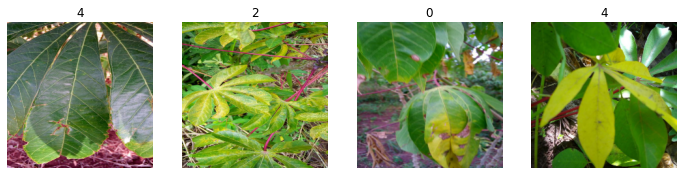

In [9]:
dls = CassavaBlock.dataloaders(train_df, batch_size=64)
dls.valid.show_batch(max_n=4, nrows=1)

### Training

The compeition does not allow internet access. Normally FastAI can obtain weights for ResNet-50 from the Internet, but now it must be done offline. Obtain weights from Kaggle dataset then copy the file over to the directory at which FastAI will expect it.

In [10]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet50/resnet50.pth' '/root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth'

Create the model and fine tune to our data, with 7 epochs.

In [11]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, loss_func = LabelSmoothingCrossEntropy(), opt_func = ranger)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.527907,1.228231,0.643375,05:55


epoch,train_loss,valid_loss,accuracy,time
0,1.147266,1.016571,0.717457,05:24
1,1.025726,0.899997,0.759991,05:20
2,0.891766,0.800036,0.805095,05:18
3,0.805494,0.799896,0.798317,05:19
4,0.779039,0.792251,0.814676,05:28
5,0.743591,0.768290,0.817714,05:21
6,0.712327,0.740646,0.838747,05:19
7,0.694283,0.722287,0.838046,05:19
8,0.681258,0.726590,0.837111,05:22
9,0.671569,0.715414,0.842019,05:33


Plot confusion matrix.

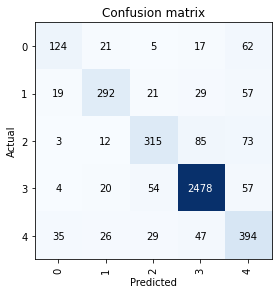

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Show worst 5 images in terms of loss - i.e. the images which the model is not predicting well on.

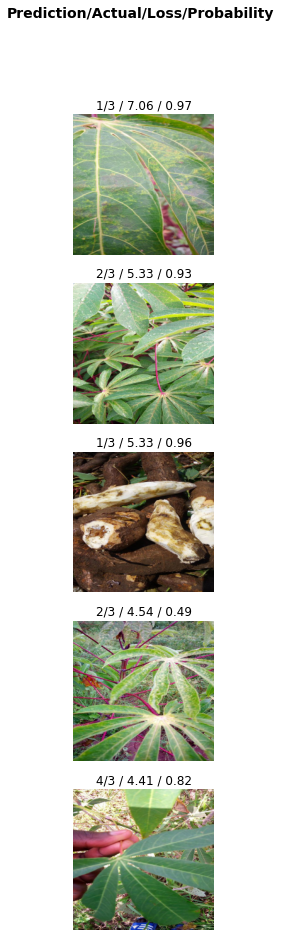

In [13]:
interp.plot_top_losses(5, nrows=5)

From the above, the predictor is confusing Mosaic Disease with other diseases, namely Brown Steak Disease and Green Mottle. An expert in Cassava plants, and plants in general, would be able to provide insight into this - further reading required.

### Predictions

In [14]:
sample_df = pd.read_csv(path/'sample_submission.csv') #Read csv
sample_df_copy = sample_df.copy() #Make copy so that when uploading original, image ids are unchanged.
sample_df_copy.head()

,image_id,label
0,2216849948.jpg,4


In [15]:
sample_df_copy['image_id'] = 'test_images/' + sample_df_copy['image_id'] #Add path to image ids

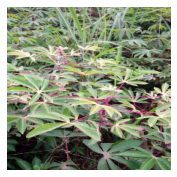

In [16]:
test_dl = dls.test_dl(sample_df_copy) #Data loader
test_dl.show_batch()

In [17]:
preds = learn.tta(dl=test_dl, n=8, beta=0) #Predictions for each class (probability)

In [18]:
sample_df['label'] = np.argmax(preds[0], axis=1) #Add prediction to original dataframe - maximum probability

In [19]:
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [20]:
sample_df.to_csv('submission.csv', index=False) #Dataframe to csv